# Прогнозирование уровня средней зарплаты в России

In [ ]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%pylab inline
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
#Считываем датасет
df = pd.read_csv('WAG_C_M.csv', sep = ';',index_col=['month'], parse_dates=['month'], dayfirst=True)
df.columns = ['salary']


Построим график и посмотрим на данные

Text(0, 0.5, 'Salary')

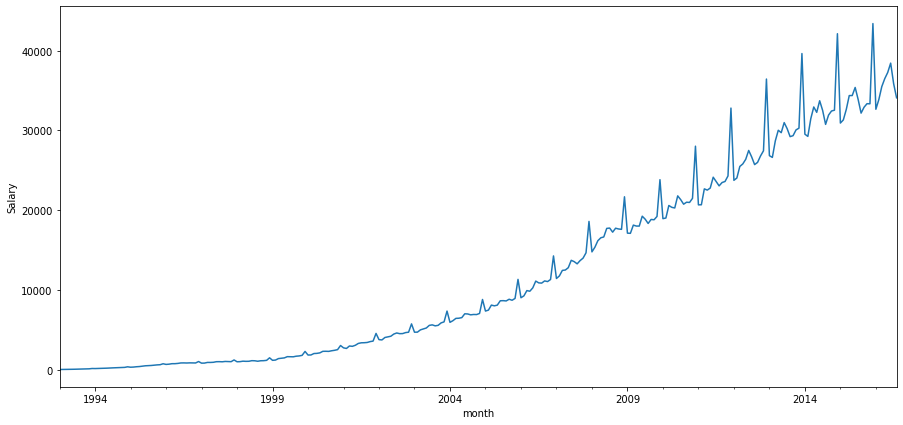

In [ ]:
plt.figure(figsize(15,7))
df.salary.plot()
plt.ylabel('Salary')

По графику виден выраженный тренд и сезонность. У ряда нестационарная дисперсия.

Проверим ряд на стационарность критерием Дики-Фуллера.

In [ ]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary)[1])

Критерий Дики-Фуллера: p=0.991850


Достигаемый уровень значимости подтвержает наше предположение, что ряд нестационарный

Посмотрим на графики компонентов нашего ряда при помощи STL-декомпозиции:

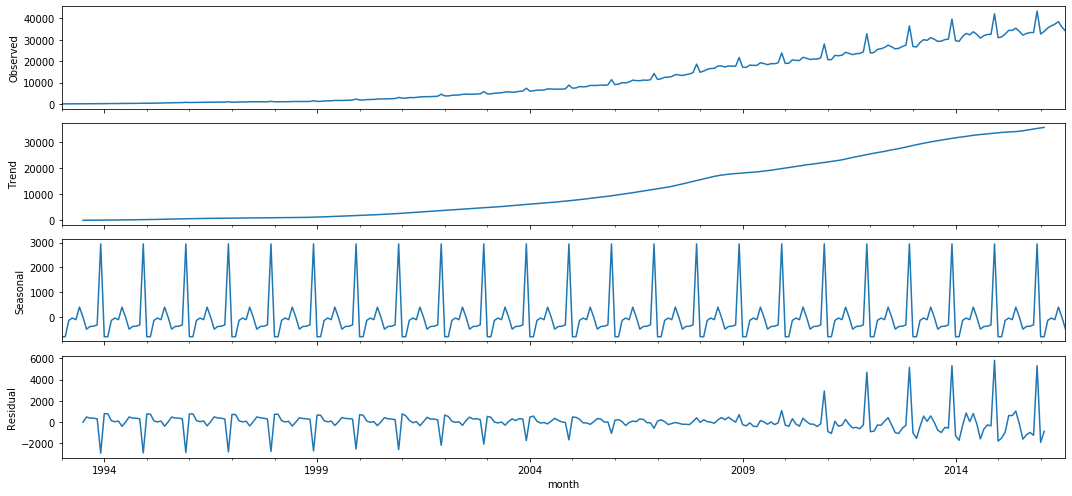

In [ ]:
sm.tsa.seasonal_decompose(df.salary).plot()
pylab.show()

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


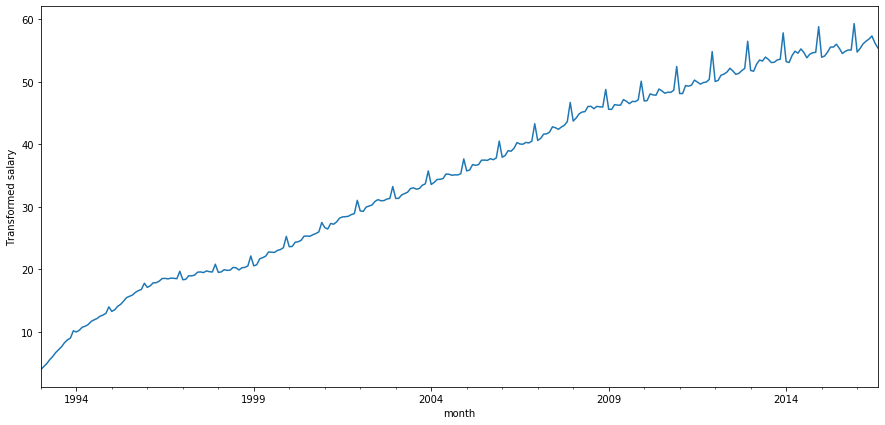

In [ ]:
df['salary_box'], lmbda = stats.boxcox(df.salary)
plt.figure(figsize(15,7))
df.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary)[1])

По графику видно, что дисперсия стабилизировалась. Тем не менее, график остается нестационарным

Попробуем выполнить сезонное дифференцирование и проверим стационарность

Критерий Дики-Фуллера: p=0.014697


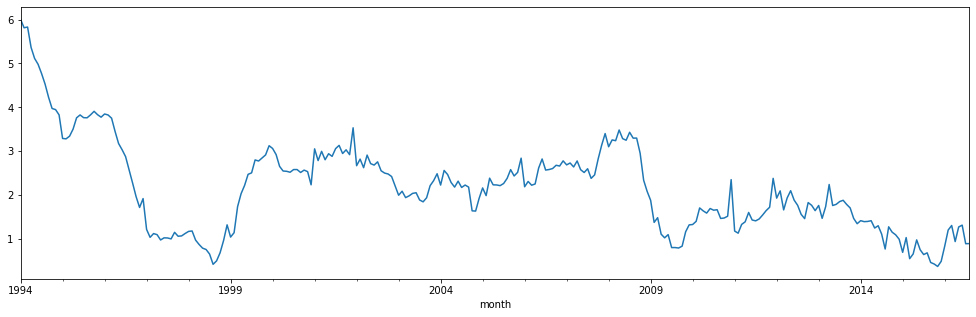

In [ ]:
df['salary_box_diff'] = df.salary_box - df.salary_box.shift(12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff[12:])[1])
plt.figure(figsize(17,5))
df.salary_box_diff[12:].plot()

Критерий Дики-Фуллера позволяет нам отколнить нулевую гипотезу, но по графику все еще виден тренд. Попробуем добавить еще обычное дифференцирование.

In [ ]:
df['salary_box_diff2'] = df.salary_box_diff - df.salary_box_diff.shift(1)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

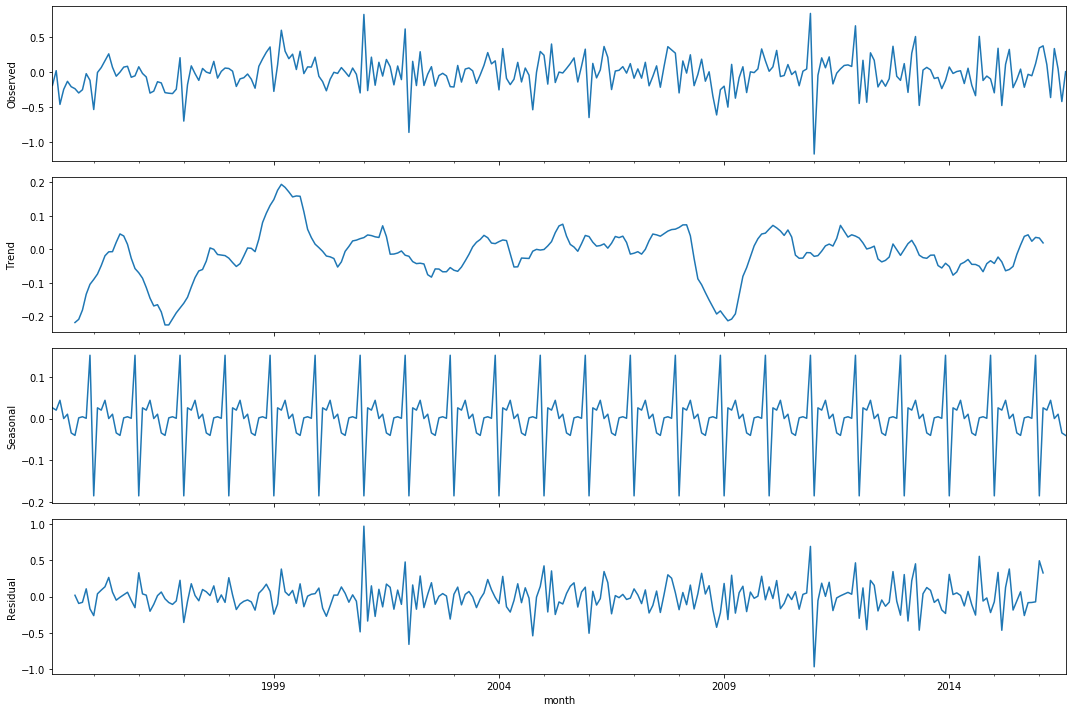

In [ ]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff2[13:]).plot()   
pylab.show()

Критерий Дики-Фуллера позволяет нам отколнить нулевую гипотезу и график это подтверждает.

Посмотрим на автокорреляционную и частично автокорреляционную функцию для получившегося ряда

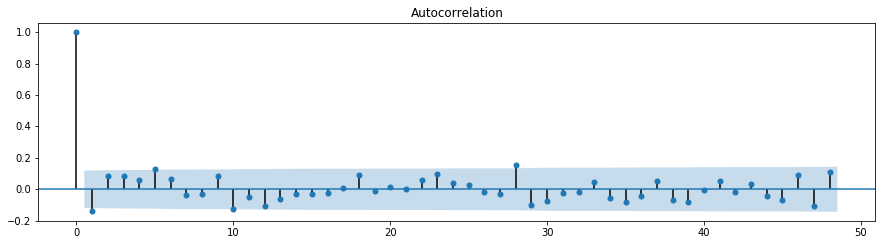

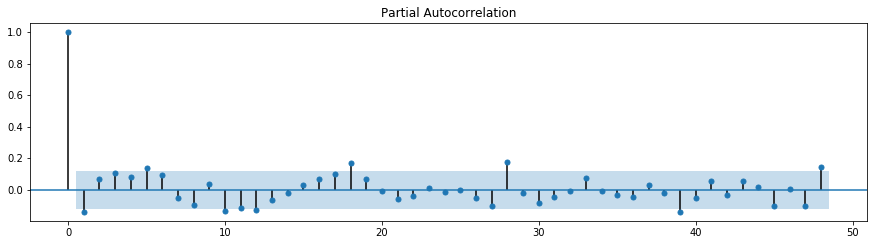

In [ ]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Подберем начальное приближение для параметров: Q=1, q=5, P=1, p=5

In [ ]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(114))

       parameters        aic
142  (5, 5, 1, 0) -25.182808
118  (4, 5, 1, 0) -24.999777
141  (5, 5, 0, 1) -24.587902
143  (5, 5, 1, 1) -24.080485
117  (4, 5, 0, 1) -23.469997
..            ...        ...
97   (4, 0, 0, 1)  -0.233488
14   (0, 3, 1, 0)  -0.168121
73   (3, 0, 0, 1)   0.065521
15   (0, 3, 1, 1)   0.164984
75   (3, 0, 1, 1)   0.228218

[114 rows x 2 columns]


Посмотрим на лучшую модель.

In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.591
Date:                            Sun, 19 Apr 2020   AIC                            -25.183
Time:                                    12:50:59   BIC                             18.043
Sample:                                01-01-1993   HQIC                            -7.827
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2222      0.840     -0.265      0.791      -1.868       1.424
ar.L2          0.2395      0.594   

Её остатки:

Критерий Стьюдента: p=0.167863
Критерий Дики-Фуллера: p=0.000000


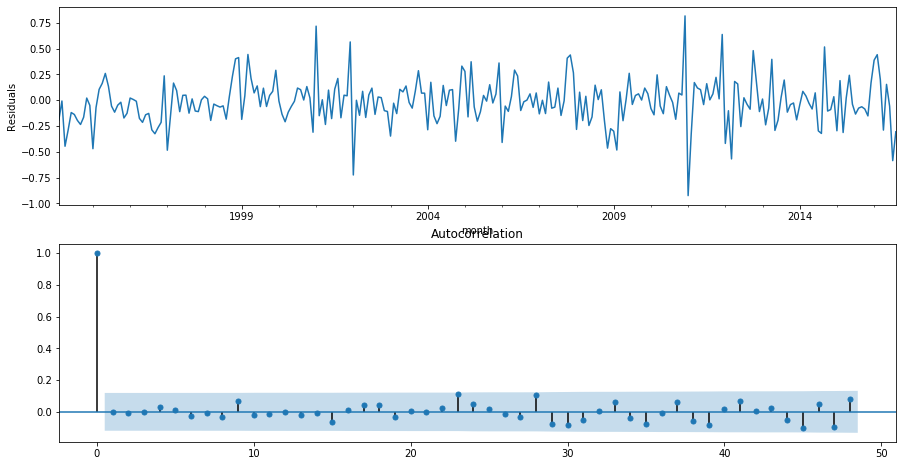

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

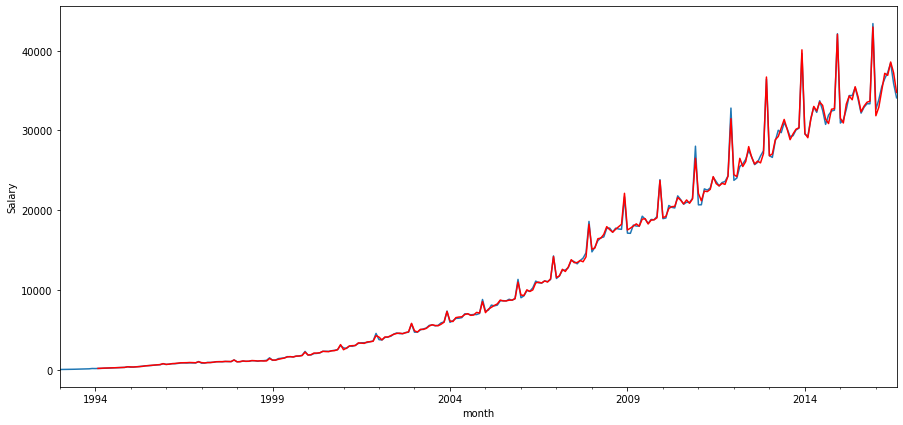

In [ ]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.salary.plot()
df.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

По графику видно, что модель хорошо описывает наши данные.

Сделаем прогноз средней зарплаты на два года вперед.

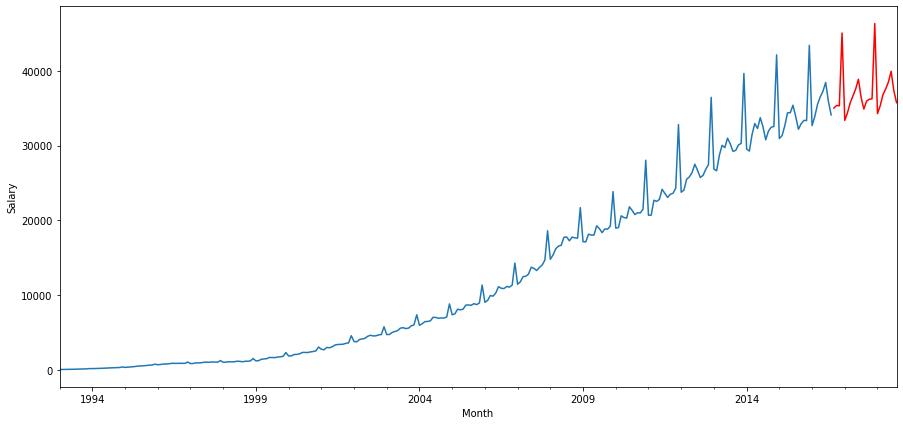

In [ ]:
df2 = df[['salary']]

date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d")+ relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])

df2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)
plt.figure(figsize(15,7))
df2.salary.plot()
df2.forecast.plot(color='r')
plt.ylabel('Salary')
plt.xlabel('Month')
pylab.show()

Прогноз выглядит правдоподобным.

Посмотрим на доступных данных насколько точный наш прогноз.

In [ ]:
actual_salary = pd.Series([35843, 35749, 36195, 47554, 34422, 35497, 37899, 39225, 39679, 41454, 38073,
                        37099, 38047, 38333, 38848, 51197, 39017, 40443, 42364, 43381, 44076, 45848, 
                         42413, 41364]) #Среднемесячная зарплата за период 2016-09-01  - 2018-08-01
actual_salary.index = df3.index

In [ ]:
df3 = df2['forecast'].tail(24)
df4 = pd.concat([df3, actual_salary], axis=1)
df4['fault'] = df4['forecast'] - df4[0]

In [ ]:
df4

,forecast,0,fault
2016-09-01,35012.397104,35843,-830.602896
2016-10-01,35365.161346,35749,-383.838654
2016-11-01,35314.420466,36195,-880.579534
2016-12-01,45057.050383,47554,-2496.949617
2017-01-01,33362.355681,34422,-1059.644319
2017-02-01,34381.224827,35497,-1115.775173
2017-03-01,35724.128905,37899,-2174.871095
2017-04-01,36625.371660,39225,-2599.628340
2017-05-01,37561.626023,39679,-2117.373977
2017-06-01,38871.702065,41454,-2582.297935


Можно заметить, что наш прогноз получился хорошим только на небольшой период времени. Чем дальше во времени, тем больше мы ошибаемся  